## Summary of data
## Properties from San Jose, CA
## 6099 condos
## 92 different neighborhoods

In [1]:
PROPERTY_TYPES = ['condo', 'townhouse', 'multiunit', 'singlefamily']
TRESH = 0.15
BINS = 10

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
          'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
         'Nov', 'Dec']

COLS_EXCLUDE = ['Median Sale Price','Region','neighborhood',
                'location','city','property_type','state',
                'Month of Period End']

In [2]:
import csv
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from string import punctuation

In [3]:
def make_histogram(data, bins):
    fig, ax = plt.subplots()

    # histogram our data with numpy
    n, bins = np.histogram(data, bins)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n


    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    plt.show()

In [4]:
# convert string percentages to numerical
def convert_percentage(df):
    for col in df.columns:
        c = col.split(" ")
        if c[-1] == "MoM" or c[-1] == "YoY": 
            df[col] = [float(str(x).strip("%")) for x in df[col]]
            df[col].fillna(method='bfill')
    
    df['Average Sale To List'] = [float(str(x).strip("%")) for x in df['Average Sale To List']]
    df['Average Sale To List'].fillna(method='bfill')
    return (df)

In [5]:
### read in data
def read_data(filename, property_type):
    df = pd.read_csv(filename)
    df.columns = [x.strip(" ") for x in df.columns]
    df['property_type'] = property_type
    df['property_type_num'] = PROPERTY_TYPES.index(property_type)
    df.head()
    return (df)

In [6]:
### add columns for city, state, and neighborhood
def parse_region(df):
    df['location'] = [x.split(",") for x in df.Region]
    df['city'] = [x[0].strip(",").lower() for x in df.location]
    df['state'] = [x[1].split(" ")[1].lower().strip() for x in df.location]
    df['neighborhood'] = [x[1].split(" ")[3].strip().lower() for x in df.location]
    df = df[df.city == 'san jose']
    df.head()

In [7]:
### convert Median Sale Price to a float
def convert_med_sale_pr(df):
    df[u'Median Sale Price'] = [x.strip("$").replace(",", "") for x in df["Median Sale Price"]]
    df[u'Median Sale Price'] = [int(x) if x[len(x)-1] != "K" else int(x.strip("K"))*1000 
                                for x in df["Median Sale Price"]]

In [8]:
### convert neighborhood to a numerical value
def convert_neighborhood(df):
    neighborhoods = df.neighborhood.unique()
    df['neighborhood_num'] = [np.where(neighborhoods == x)[0][0] for x in df.neighborhood]

In [9]:
def bin_med_sale_pr(df, bins):
    med_sale_pr = df['Median Sale Price']
    bins = np.linspace(med_sale_pr.min(), med_sale_pr.max(), bins)
    digitized = np.digitize(med_sale_pr, bins)
    df['Median_Sale_Price_Bin'] = digitized
    return (df)

In [10]:
def parse_date(df):
    df['Month of Period End'] = [x.replace('-', ' ') for x in df['Month of Period End']]
    df['Month'] = [MONTHS.index(x.split(' ')[0][:3]) for x in df['Month of Period End']]
    df['Year'] = [int(x.split(' ')[1]) for x in df['Month of Period End']]
    return (df)

In [11]:
### given the filename and property type return
### a dataframe with string fields converted to
### numerical and regions parsed out
def clean_data(filename, property_type):
    df = read_data(filename, property_type)
    convert_med_sale_pr(df)
    parse_region(df)
    df = convert_percentage(df)
    convert_neighborhood(df)
    df = parse_date(df)
    df = bin_med_sale_pr(df, BINS)
    return (df)

In [12]:
# merge several dataframes together
# files = list of tuples, 
# each tuple should contain filename first then property type

# How to deal with NA's? fill with 0 for now ...
def merge_data(files):
    frames = []
    for f in files:
        frames.append(clean_data(f[0], f[1]))
    return (pd.concat(frames).fillna(0))

In [13]:
# x_train has 70% of the dataset
# x_test has 30% of the dataset
# ignore y_train and y_test
# Regression: Train on x_train, remove non-numerical columns first!
# Test on x_test

# splits dataset up into training (70%) and testing (30%) sets
# evenly based on neighborhood

def split_test_train(total, stratify_col):
    total2 = total.copy(deep=True)
    y = total2[stratify_col]
    x = total2
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
    return (x_train, x_test, y_train, y_test)

In [14]:
# fits a regression model to a training set
def model(x_train, reg):
    X = x_train.loc[:, x_train.columns.difference(COLS_EXCLUDE)]
    Y = x_train.loc[:, 'Median Sale Price']
    reg.fit(X, Y)
    return (reg)

In [15]:
def predict(x_test, reg):
    X_test = x_test.loc[:, x_train.columns.difference(COLS_EXCLUDE)]
    Y_test = x_test.loc[:, 'Median Sale Price']
    return (reg.predict(X_test), Y_test)


In [16]:
# how many of the predicted prices were within
# thresh % of the actual price?
# return a ratio

def evaluate(y_pred, y_test, thresh):
    assert len(y_pred) == len(y_test)
    result = []
    for (pred, test) in zip(y_pred, y_test):
        result.append(math.fabs((test-pred)/test) <= thresh)
    
    return (float(sum(result))/float(len(result)))

In [17]:
files = [('sanjose_condos.csv', PROPERTY_TYPES[0]), ('sanjose_townhouse2.csv', PROPERTY_TYPES[1]),
        ('sanjose_multiunit.csv', PROPERTY_TYPES[2]), ("sanjose_singlefamily.csv", PROPERTY_TYPES[3])]
total = merge_data(files)

In [32]:
total.columns

Index([u'Region', u'Month of Period End', u'Median Sale Price',
       u'Median Sale Price MoM', u'Median Sale Price YoY', u'Homes Sold',
       u'Homes Sold MoM', u'Homes Sold YoY', u'New Listings',
       u'New Listings MoM', u'New Listings YoY', u'Inventory',
       u'Inventory MoM', u'Inventory YoY', u'Days on Market',
       u'Days on Market MoM', u'Days on Market YoY', u'Average Sale To List',
       u'Average Sale To List MoM', u'Average Sale To List YoY',
       u'property_type', u'property_type_num', u'location', u'city', u'state',
       u'neighborhood', u'neighborhood_num', u'Month', u'Year',
       u'Median_Sale_Price_Bin'],
      dtype='object')

In [18]:
total.head()

,Region,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,New Listings MoM,...,property_type,property_type_num,location,city,state,neighborhood,neighborhood_num,Month,Year,Median_Sale_Price_Bin
0,"San Jose, CA - Alexander",January 2012,152000,-1.0,18.8,12,-7.7,100.0,12.0,0.0,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,0,2012,1
1,"San Jose, CA - Alexander",February 2012,146000,-4.0,-1.7,10,-16.7,42.9,11.0,-8.3,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,1,2012,1
2,"San Jose, CA - Alexander",March 2012,146000,0.0,-7.0,13,30.0,116.7,12.0,9.1,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,2,2012,1
3,"San Jose, CA - Alexander",April 2012,140000,-3.6,-7.4,10,-23.1,25.0,5.0,-58.3,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,3,2012,1
4,"San Jose, CA - Alexander",May 2012,150000,7.0,12.8,11,10.0,0.0,8.0,60.0,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,4,2012,1


In [29]:
x_train, x_test, _, _ = split_test_train(total, 'Median_Sale_Price_Bin')
reg = model(x_train, linear_model.Lasso(alpha=0.5))

np.set_printoptions(precision=3, suppress=True)
cols = x_train.loc[:, x_train.columns.difference(COLS_EXCLUDE)].columns
coeff = np.array(reg.coef_)

for (col, coeff) in zip(cols, coeff):
    print (col,coeff)

('Average Sale To List', 1977.4372765833959)
('Average Sale To List MoM', -564.93034311678753)
('Average Sale To List YoY', -1195.1447500354539)
('Days on Market', -154.06102356196376)
('Days on Market MoM', 8.5851331374364808)
('Days on Market YoY', 71.351924522824646)
('Homes Sold', -10.854543475302112)
('Homes Sold MoM', 16.580515363875513)
('Homes Sold YoY', 11.778862056446281)
('Inventory', 3.0790342209491137)
('Inventory MoM', 1.5257491710772348)
('Inventory YoY', 12.440900435771692)
('Median Sale Price MoM', 168.64380728675997)
('Median Sale Price YoY', 44.874536382823862)
('Median_Sale_Price_Bin', 218146.90195767206)
('Month', 336.41346975902286)
('New Listings', 0.77503745500617349)
('New Listings MoM', 38.429606442810964)
('New Listings YoY', 10.776222255687195)
('Year', 59.687181322639709)
('neighborhood_num', 70.831045219654996)
('property_type_num', 40690.672692753353)


In [20]:
Y_pred, Y_test = predict(x_test, reg)

In [26]:
for t in [0.05, 0.10, 0.15, 0.25]:
    print (evaluate(Y_pred, Y_test, t))

0.311932555123
0.584738434933
0.79766536965
0.940121054907


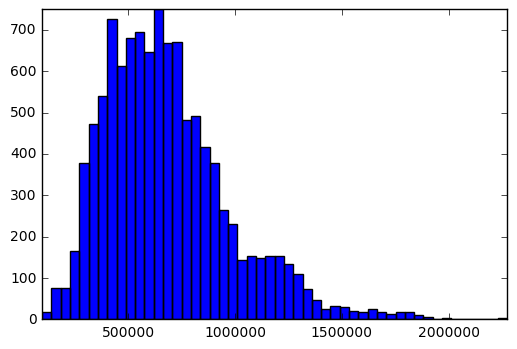

In [30]:
make_histogram(x_train['Median Sale Price'], 50)

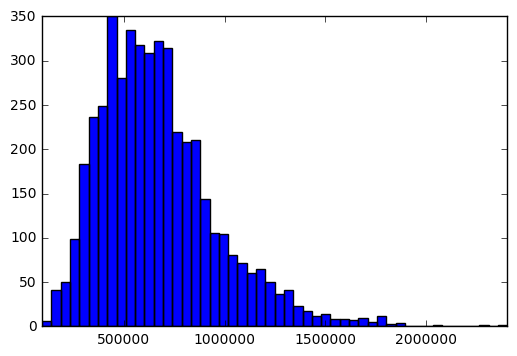

In [31]:
make_histogram(x_test['Median Sale Price'], 50)